In [1]:
import torch
#import torchaudio
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [2]:
# import torch
# import sys
# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION', )
# from subprocess import call
# # call(["nvcc", "--version"]) does not work
# ! nvcc --version
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# # call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
# print('Active CUDA Device: GPU', torch.cuda.current_device())
# print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device())

In [3]:
# #!pip install pycuda
# import pycuda.driver as cuda
# cuda.init()
# #Get ID of default device
# torch.cuda.current_device()
# cuda.Device(0).name()#0 is the ID of your GPU

In [4]:
!nvidia-smi

Sun Nov 22 12:10:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P0    51W / 180W |    585MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# utils.py:

In [5]:
# Created on 2018/12
# Author: Kaituo XU

import math

import torch


def overlap_and_add(signal, frame_step):
    """Reconstructs a signal from a framed representation.

    Adds potentially overlapping frames of a signal with shape
    `[..., frames, frame_length]`, offsetting subsequent frames by `frame_step`.
    The resulting tensor has shape `[..., output_size]` where

        output_size = (frames - 1) * frame_step + frame_length

    Args:
        signal: A [..., frames, frame_length] Tensor. All dimensions may be unknown, and rank must be at least 2.
        frame_step: An integer denoting overlap offsets. Must be less than or equal to frame_length.

    Returns:
        A Tensor with shape [..., output_size] containing the overlap-added frames of signal's inner-most two dimensions.
        output_size = (frames - 1) * frame_step + frame_length

    Based on https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/contrib/signal/python/ops/reconstruction_ops.py
    """
    outer_dimensions = signal.size()[:-2]
    frames, frame_length = signal.size()[-2:]

    subframe_length = math.gcd(frame_length, frame_step)  # gcd=Greatest Common Divisor
    subframe_step = frame_step // subframe_length
    subframes_per_frame = frame_length // subframe_length
    output_size = frame_step * (frames - 1) + frame_length
    output_subframes = output_size // subframe_length

    subframe_signal = signal.view(*outer_dimensions, -1, subframe_length)

    frame = torch.arange(0, output_subframes).unfold(0, subframes_per_frame, subframe_step)
    frame = signal.new_tensor(frame).long()  # signal may in GPU or CPU
    frame = frame.contiguous().view(-1)

    result = signal.new_zeros(*outer_dimensions, output_subframes, subframe_length)
    result.index_add_(-2, frame, subframe_signal)
    result = result.view(*outer_dimensions, -1)
    return result


def remove_pad(inputs, inputs_lengths):
    """
    Args:
        inputs: torch.Tensor, [B, C, T] or [B, T], B is batch size
        inputs_lengths: torch.Tensor, [B]
    Returns:
        results: a list containing B items, each item is [C, T], T varies
    """
    results = []
    dim = inputs.dim()
    if dim == 3:
        C = inputs.size(1)
    for input, length in zip(inputs, inputs_lengths):
        if dim == 3: # [B, C, T]
            results.append(input[:,:length].view(C, -1).cpu().numpy())
        elif dim == 2:  # [B, T]
            results.append(input[:length].view(-1).cpu().numpy())
    return results

#%%
if __name__ == '__main__':
    torch.manual_seed(123)
    M, C, K, N = 2, 2, 3, 4
    frame_step = 2
    signal = torch.randint(5, (M, C, K, N))
    result = overlap_and_add(signal, frame_step)
    print(signal)
    print(result)


tensor([[[[2., 4., 2., 0.],
          [0., 2., 1., 2.],
          [4., 4., 1., 1.]],

         [[1., 1., 2., 4.],
          [4., 1., 3., 0.],
          [0., 1., 0., 2.]]],


        [[[4., 2., 1., 1.],
          [0., 1., 1., 0.],
          [3., 4., 4., 1.]],

         [[1., 3., 0., 0.],
          [4., 1., 1., 2.],
          [3., 1., 2., 2.]]]])
tensor([[[2., 4., 2., 2., 5., 6., 1., 1.],
         [1., 1., 6., 5., 3., 1., 0., 2.]],

        [[4., 2., 1., 2., 4., 4., 4., 1.],
         [1., 3., 4., 1., 4., 3., 2., 2.]]])


# conv_tasnet.py:

In [6]:
# Created on 2018/12
# Author: Kaituo XU

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import overlap_and_add

EPS = 1e-8


class ConvTasNet(nn.Module):
    def __init__(self, N, L, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            L: Length of the filters (in samples)
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(ConvTasNet, self).__init__()
        # Hyper-parameter
        self.N, self.L, self.B, self.H, self.P, self.X, self.R, self.C = N, L, B, H, P, X, R, C
        self.norm_type = norm_type
        self.causal = causal
        self.mask_nonlinear = mask_nonlinear
        # Components
        self.encoder = Encoder(L, N)
        self.separator = TemporalConvNet(N, B, H, P, X, R, C, norm_type, causal, mask_nonlinear)
        self.decoder = Decoder(N, L)
        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            est_source: [M, C, T]
        """
        mixture_w = self.encoder(mixture)
        est_mask = self.separator(mixture_w)
        est_source = self.decoder(mixture_w, est_mask)

        # T changed after conv1d in encoder, fix it here
        T_origin = mixture.size(-1)
        T_conv = est_source.size(-1)
        est_source = F.pad(est_source, (0, T_origin - T_conv))
        return est_source

    @classmethod
    def load_model(cls, path):
        # Load to CPU
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = cls.load_model_from_package(package)
        return model

    @classmethod
    def load_model_from_package(cls, package):
        model = cls(package['N'], package['L'], package['B'], package['H'],
                    package['P'], package['X'], package['R'], package['C'],
                    norm_type=package['norm_type'], causal=package['causal'],
                    mask_nonlinear=package['mask_nonlinear'])
        model.load_state_dict(package['state_dict'])
        return model

    @staticmethod
    def serialize(model, optimizer, epoch, tr_loss=None, cv_loss=None):
        package = {
            # hyper-parameter
            'N': model.N, 'L': model.L, 'B': model.B, 'H': model.H,
            'P': model.P, 'X': model.X, 'R': model.R, 'C': model.C,
            'norm_type': model.norm_type, 'causal': model.causal,
            'mask_nonlinear': model.mask_nonlinear,
            # state
            'state_dict': model.state_dict(),
            'optim_dict': optimizer.state_dict(),
            'epoch': epoch
        }
        if tr_loss is not None:
            package['tr_loss'] = tr_loss
            package['cv_loss'] = cv_loss
        return package


class Encoder(nn.Module):
    """Estimation of the nonnegative mixture weight by a 1-D conv layer.
    """
    def __init__(self, L, N):
        super(Encoder, self).__init__()
        # Hyper-parameter
        self.L, self.N = L, N
        # Components
        # 50% overlap
        self.conv1d_U = nn.Conv1d(1, N, kernel_size=L, stride=L // 2, bias=False)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            mixture_w: [M, N, K], where K = (T-L)/(L/2)+1 = 2T/L-1
        """
        mixture = torch.unsqueeze(mixture, 1)  # [M, 1, T]
        mixture_w = F.relu(self.conv1d_U(mixture))  # [M, N, K]
        return mixture_w


class Decoder(nn.Module):
    def __init__(self, N, L):
        super(Decoder, self).__init__()
        # Hyper-parameter
        self.N, self.L = N, L
        # Components
        self.basis_signals = nn.Linear(N, L, bias=False)

    def forward(self, mixture_w, est_mask):
        """
        Args:
            mixture_w: [M, N, K]
            est_mask: [M, C, N, K]
        Returns:
            est_source: [M, C, T]
        """
        # D = W * M
        #fatemeh: size(torch.unsqueeze()):torch.Size([2, 1, 3, 5]) , size(est_mask):torch.Size([2, 5, 2, 3])
        source_w = torch.unsqueeze(mixture_w, 1) * est_mask  # [M, C, N, K]
        source_w = torch.transpose(source_w, 2, 3) # [M, C, K, N]
        # S = DV
        est_source = self.basis_signals(source_w)  # [M, C, K, L]
        est_source = overlap_and_add(est_source, self.L//2) # M x C x T
        return est_source


class TemporalConvNet(nn.Module):
    def __init__(self, N, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(TemporalConvNet, self).__init__()
        # Hyper-parameter
        self.C = C
        self.mask_nonlinear = mask_nonlinear
        # Components
        # [M, N, K] -> [M, N, K]
        layer_norm = ChannelwiseLayerNorm(N)
        # [M, N, K] -> [M, B, K]
        bottleneck_conv1x1 = nn.Conv1d(N, B, 1, bias=False)
        # [M, B, K] -> [M, B, K]
        repeats = []
        for r in range(R):
            blocks = []
            for x in range(X):
                dilation = 2**x
                padding = (P - 1) * dilation if causal else (P - 1) * dilation // 2
                blocks += [TemporalBlock(B, H, P, stride=1,
                                         padding=padding,
                                         dilation=dilation,
                                         norm_type=norm_type,
                                         causal=causal)]
            repeats += [nn.Sequential(*blocks)]
        temporal_conv_net = nn.Sequential(*repeats)
        # [M, B, K] -> [M, C*N, K]
        mask_conv1x1 = nn.Conv1d(B, C*N, 1, bias=False)
        # Put together
        self.network = nn.Sequential(layer_norm,
                                     bottleneck_conv1x1,
                                     temporal_conv_net,
                                     mask_conv1x1)

    def forward(self, mixture_w):
        """
        Keep this API same with TasNet
        Args:
            mixture_w: [M, N, K], M is batch size
        returns:
            est_mask: [M, C, N, K]
        """
        M, N, K = mixture_w.size()
        score = self.network(mixture_w)  # [M, N, K] -> [M, C*N, K]
        score = score.view(M, self.C, N, K) # [M, C*N, K] -> [M, C, N, K]
        if self.mask_nonlinear == 'softmax':
            est_mask = F.softmax(score, dim=1)
        elif self.mask_nonlinear == 'relu':
            est_mask = F.relu(score)
        else:
            raise ValueError("Unsupported mask non-linear function")
        return est_mask


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation, norm_type="gLN", causal=False):
        super(TemporalBlock, self).__init__()
        # [M, B, K] -> [M, H, K]
        conv1x1 = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        prelu = nn.PReLU()
        norm = chose_norm(norm_type, out_channels)
        # [M, H, K] -> [M, B, K]
        dsconv = DepthwiseSeparableConv(out_channels, in_channels, kernel_size,
                                        stride, padding, dilation, norm_type,
                                        causal)
        # Put together
        self.net = nn.Sequential(conv1x1, prelu, norm, dsconv)

    def forward(self, x):
        """
        Args:
            x: [M, B, K]
        Returns:
            [M, B, K]
        """
        residual = x
        out = self.net(x)
        # TODO: when P = 3 here works fine, but when P = 2 maybe need to pad?
        return out + residual  # look like w/o F.relu is better than w/ F.relu
        # return F.relu(out + residual)


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation, norm_type="gLN", causal=False):
        super(DepthwiseSeparableConv, self).__init__()
        # Use `groups` option to implement depthwise convolution
        # [M, H, K] -> [M, H, K]
        depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size,
                                   stride=stride, padding=padding,
                                   dilation=dilation, groups=in_channels,
                                   bias=False)
        if causal:
            chomp = Chomp1d(padding)
        prelu = nn.PReLU()
        norm = chose_norm(norm_type, in_channels)
        # [M, H, K] -> [M, B, K]
        pointwise_conv = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        # Put together
        if causal:
            self.net = nn.Sequential(depthwise_conv, chomp, prelu, norm,
                                     pointwise_conv)
        else:
            self.net = nn.Sequential(depthwise_conv, prelu, norm,
                                     pointwise_conv)

    def forward(self, x):
        """
        Args:
            x: [M, H, K]
        Returns:
            result: [M, B, K]
        """
        return self.net(x)


class Chomp1d(nn.Module):
    """To ensure the output length is the same as the input.
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        Args:
            x: [M, H, Kpad]
        Returns:
            [M, H, K]
        """
        return x[:, :, :-self.chomp_size].contiguous()


def chose_norm(norm_type, channel_size):
    """The input of normlization will be (M, C, K), where M is batch size,
       C is channel size and K is sequence length.
    """
    if norm_type == "gLN":
        return GlobalLayerNorm(channel_size)
    elif norm_type == "cLN":
        return ChannelwiseLayerNorm(channel_size)
    else: # norm_type == "BN":
        # Given input (M, C, K), nn.BatchNorm1d(C) will accumulate statics
        # along M and K, so this BN usage is right.
        return nn.BatchNorm1d(channel_size)


# TODO: Use nn.LayerNorm to impl cLN to speed up
class ChannelwiseLayerNorm(nn.Module):
    """Channel-wise Layer Normalization (cLN)"""
    def __init__(self, channel_size):
        super(ChannelwiseLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(1, channel_size, 1))  # [1, N, 1]
        self.beta = nn.Parameter(torch.Tensor(1, channel_size,1 ))  # [1, N, 1]
        self.reset_parameters()

    def reset_parameters(self):
        self.gamma.data.fill_(1)
        self.beta.data.zero_()

    def forward(self, y):
        """
        Args:
            y: [M, N, K], M is batch size, N is channel size, K is length
        Returns:
            cLN_y: [M, N, K]
        """
        #fatemeh : set float
        y=y.float()
        mean = torch.mean(y, dim=1, keepdim=True)  # [M, 1, K]
        var = torch.var(y, dim=1, keepdim=True, unbiased=False)  # [M, 1, K]
        cLN_y = self.gamma * (y - mean) / torch.pow(var + EPS, 0.5) + self.beta
        return cLN_y


class GlobalLayerNorm(nn.Module):
    """Global Layer Normalization (gLN)"""
    def __init__(self, channel_size):
        super(GlobalLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(1, channel_size, 1))  # [1, N, 1]
        self.beta = nn.Parameter(torch.Tensor(1, channel_size,1 ))  # [1, N, 1]
        self.reset_parameters()

    def reset_parameters(self):
        self.gamma.data.fill_(1)
        self.beta.data.zero_()

    def forward(self, y):
        """
        Args:
            y: [M, N, K], M is batch size, N is channel size, K is length
        Returns:
            gLN_y: [M, N, K]
        """
        # TODO: in torch 1.0, torch.mean() support dim list
        mean = y.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True) #[M, 1, 1]
        var = (torch.pow(y-mean, 2)).mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        gLN_y = self.gamma * (y - mean) / torch.pow(var + EPS, 0.5) + self.beta
        return gLN_y
#%%

if __name__ == "__main__":
    torch.manual_seed(123)
    M, N, L, T = 2, 3, 4, 12
    #K = (T-L)/(L/2)+1
    K = 2*T//L-1
    B, H, P, X, R, C, norm_type, causal = 2, 3, 3, 3, 2, 2, "gLN", False
    mixture = torch.randint(3, (M, T))
#%%
    # test Encoder
    encoder = Encoder(L, N)
    encoder.conv1d_U.weight.data = torch.randint(2, encoder.conv1d_U.weight.size())
    mixture_w = encoder(mixture)
    print('mixture', mixture)
    print('U', encoder.conv1d_U.weight)
    print('mixture_w', mixture_w)
    print('mixture_w size', mixture_w.size())
#%%
    # test TemporalConvNet
    separator = TemporalConvNet(N, B, H, P, X, R, C, norm_type=norm_type, causal=causal)
    est_mask = separator(mixture_w)
    print('est_mask', est_mask)
#%%
    #fatemeh:error!!!with est_mask
    # test Decoder
    decoder = Decoder(N, L)
    #est_mask = torch.randint(2, (B, K, C, N))
    est_source = decoder(mixture_w, est_mask)
    print('est_source', est_source)

#%%
    
    #fatemeh: I put a mixture x as input instead of randint for mixture above
    # test Conv-TasNet
    import os
    
    audio_path='/home/speech/f_torch/bin/newdata/data/tr/mix/tr_mix_3_23_.wav'
    import librosa
    data, sr = librosa.load(audio_path)
    x = torch.from_numpy(data)
    mixture=x
    x=x.reshape(2,len(mixture)//2)
    
    conv_tasnet = ConvTasNet(N, L, B, H, P, X, R, C, norm_type=norm_type)
    est_source = conv_tasnet(x)
    print('est_source', est_source)
    print('est_source size', est_source.size())
#%%
    import matplotlib.pyplot as plt
    import librosa
    import numpy
    mix_audio_path='/home/speech/f_torch/bin/newdata/data/tr/mix/tr_mix_3_23_.wav'
    data, sr = librosa.load(mix_audio_path)
    plt.figure()
    plt.plot(data)
    plt.title('mix')

    import numpy as np
    import soundfile as sf
#data, sr = librosa.load(mix_audio_path)
    d=est_source.detach().numpy()
    samplerate=sr
#rate = 44100
#data = np.random.uniform(-1, 1, size=(rate * 10, 2))
    s_path='est_source.wav'
# Write out audio as 24bit PCM WAV

#data, sr = librosa.load(s_path)
#plt.figure()
#plt.plot(data)
#plt.title('s')



mixture tensor([[1., 1., 0., 0., 1., 2., 0., 2., 2., 1., 2., 1.],
        [0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.]])
U Parameter containing:
tensor([[[1., 0., 0., 1.]],

        [[0., 1., 0., 1.]],

        [[1., 1., 0., 0.]]], requires_grad=True)
mixture_w tensor([[[1., 2., 3., 1., 3.],
         [1., 2., 4., 3., 2.],
         [2., 0., 3., 2., 3.]],

        [[0., 1., 1., 2., 1.],
         [1., 0., 1., 2., 1.],
         [1., 1., 0., 2., 2.]]], grad_fn=<ReluBackward>)
mixture_w size torch.Size([2, 3, 5])
est_mask tensor([[[[0.1345, 0.0000, 0.0000, 0.0486, 0.0000],
          [0.0000, 0.0000, 0.4120, 0.0000, 0.0099],
          [1.2053, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[1.3484, 0.0000, 0.0000, 0.5841, 0.0000],
          [0.0000, 0.0000, 0.4588, 0.0000, 0.0332],
          [0.9679, 0.0000, 0.0150, 0.0000, 0.0000]]],


        [[[0.0245, 0.1034, 0.0254, 0.0332, 0.0556],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.8334, 0.0422, 0.0000, 0.7139]],

RuntimeError: shape '[2, 61458]' is invalid for input of size 122917

# preprocess.py:

In [ ]:
#!/usr/bin/env python
# Created on 2018/12
# Author: Kaituo XU

#import argparse
import json
import os

import librosa


def preprocess_one_dir(in_dir, out_dir, out_filename, sample_rate=16000):
    file_infos = []
    in_dir = os.path.abspath(in_dir)
    wav_list = os.listdir(in_dir)
    for wav_file in wav_list:
        if not wav_file.endswith('.wav'):
            continue
        wav_path = os.path.join(in_dir, wav_file)
        samples, _ = librosa.load(wav_path, sr=sample_rate)
        file_infos.append((wav_path, len(samples)))
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    with open(os.path.join(out_dir, out_filename + '.json'), 'w') as f:
        json.dump(file_infos, f, indent=4)




#fatemeh#def preprocess(args):
  #fatemeh#  for data_type in ['tr', 'cv', 'tt']:
  #fatemeh#      for speaker in ['mix', 's1', 's2']:
  #fatemeh#          preprocess_one_dir(os.path.join(args.in_dir, data_type, speaker),
  #fatemeh#                             os.path.join(args.out_dir, data_type),
  #fatemeh#                             speaker,
  #fatemeh#                             sample_rate=args.sample_rate)
            
#fatemeh delete args
def preprocess(in_dir,out_dir,sample_rate):
    for data_type in ['tr', 'cv', 'tt']:
        for speaker in ['mix', 's1', 's2']:
            preprocess_one_dir(os.path.join(in_dir, data_type, speaker),
                               os.path.join(out_dir, data_type),
                               speaker,
                               sample_rate=sample_rate)
#%%
if __name__ == "__main__":
    in_dir="/home/speech/f_torch/bin/stream_data_1sec/data"

    out_dir="/home/speech/f_torch/bin/stream_data_1sec/outdata"
    sample_rate=16000
    preprocess(in_dir,out_dir,sample_rate)
    #fatemeh#parser = argparse.ArgumentParser("WSJ0 data preprocessing")
    #fatemeh#parser.add_argument('--in-dir', type=str, default=None,
    #fatemeh#                    help='Directory path of wsj0 including tr, cv and tt')
    #fatemeh#parser.add_argument('--out-dir', type=str, default=None,
    #fatemeh#                    help='Directory path to put output files')
    #fatemeh#parser.add_argument('--sample-rate', type=int, default=8000,
    #fatemeh#                    help='Sample rate of audio file')
    #fatemeh#args = parser.parse_args()
    #fatemeh#print(args)
    #fatemeh#preprocess(args)


# data.py

In [7]:
# Created on 2018/12
# Author: Kaituo XU
"""
Logic:
1. AudioDataLoader generate a minibatch from AudioDataset, the size of this
   minibatch is AudioDataLoader's batchsize. For now, we always set
   AudioDataLoader's batchsize as 1. The real minibatch size we care about is
   set in AudioDataset's __init__(...). So actually, we generate the
   information of one minibatch in AudioDataset.
2. After AudioDataLoader getting one minibatch from AudioDataset,
   AudioDataLoader calls its collate_fn(batch) to process this minibatch.

Input:
    Mixtured WJS0 tr, cv and tt path
Output:
    One batch at a time.
    Each inputs's shape is B x T
    Each targets's shape is B x C x T
"""

import json
import math
import os

import numpy as np
import torch
import torch.utils.data as data

import librosa


class AudioDataset(data.Dataset):

    def __init__(self, json_dir, batch_size, sample_rate=16000, segment=-1, cv_maxlen=8.0):
        """
        Args:
            json_dir: directory including mix.json, s1.json and s2.json
            segment: duration of audio segment, when set to -1, use full audio

        xxx_infos is a list and each item is a tuple (wav_file, #samples)
        """
        super(AudioDataset, self).__init__()
        mix_json = os.path.join(json_dir, 'mix.json')
        s1_json = os.path.join(json_dir, 's1.json')
        s2_json = os.path.join(json_dir, 's2.json')
        with open(mix_json, 'r') as f:
            mix_infos = json.load(f)
        with open(s1_json, 'r') as f:
            s1_infos = json.load(f)
        with open(s2_json, 'r') as f:
            s2_infos = json.load(f)
        # sort it by #samples (impl bucket)
        def sort(infos): return sorted(
            infos, key=lambda info: int(info[1]), reverse=True)
        sorted_mix_infos = sort(mix_infos)
        sorted_s1_infos = sort(s1_infos)
        sorted_s2_infos = sort(s2_infos)
        if segment >= 0.0:
            # segment length and count dropped utts
            segment_len = int(segment * sample_rate)  # 4s * 8000/s = 32000 samples
            drop_utt, drop_len = 0, 0
            for _, sample in sorted_mix_infos:
                if sample < segment_len:
                    drop_utt += 1
                    drop_len += sample
            print("Drop {} utts({:.2f} h) which is short than {} samples".format(
                drop_utt, drop_len/sample_rate/36000, segment_len))
            # generate minibach infomations
            minibatch = []
            start = 0
            while True:
                num_segments = 0
                end = start
                part_mix, part_s1, part_s2 = [], [], []
                while num_segments < batch_size and end < len(sorted_mix_infos):
                    utt_len = int(sorted_mix_infos[end][1])
                    if utt_len >= segment_len:  # skip too short utt
                        num_segments += math.ceil(utt_len / segment_len)
                        # Ensure num_segments is less than batch_size
                        if num_segments > batch_size:
                            # if num_segments of 1st audio > batch_size, skip it
                            if start == end: end += 1
                            break
                        part_mix.append(sorted_mix_infos[end])
                        part_s1.append(sorted_s1_infos[end])
                        part_s2.append(sorted_s2_infos[end])
                    end += 1
                if len(part_mix) > 0:
                    minibatch.append([part_mix, part_s1, part_s2,
                                      sample_rate, segment_len])
                if end == len(sorted_mix_infos):
                    break
                start = end
            self.minibatch = minibatch
        else:  # Load full utterance but not segment
            # generate minibach infomations
            minibatch = []
            start = 0
            while True:
                end = min(len(sorted_mix_infos), start + batch_size)
                # Skip long audio to avoid out-of-memory issue
                if int(sorted_mix_infos[start][1]) > cv_maxlen * sample_rate:
                    start = end
                    continue
                minibatch.append([sorted_mix_infos[start:end],
                                  sorted_s1_infos[start:end],
                                  sorted_s2_infos[start:end],
                                  sample_rate, segment])
                if end == len(sorted_mix_infos):
                    break
                start = end
            self.minibatch = minibatch

    def __getitem__(self, index):
        return self.minibatch[index]

    def __len__(self):
        return len(self.minibatch)


class AudioDataLoader(data.DataLoader):
    """
    NOTE: just use batchsize=1 here, so drop_last=True makes no sense here.
    """

    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn


def _collate_fn(batch):
    """
    Args:
        batch: list, len(batch) = 1. See AudioDataset.__getitem__()
    Returns:
        mixtures_pad: B x T, torch.Tensor
        ilens : B, torch.Tentor
        sources_pad: B x C x T, torch.Tensor
    """
    # batch should be located in list
    assert len(batch) == 1
    mixtures, sources = load_mixtures_and_sources(batch[0])

    # get batch of lengths of input sequences
    ilens = np.array([mix.shape[0] for mix in mixtures])

    # perform padding and convert to tensor
    pad_value = 0
    mixtures_pad = pad_list([torch.from_numpy(mix).float()
                             for mix in mixtures], pad_value)
    ilens = torch.from_numpy(ilens)
    sources_pad = pad_list([torch.from_numpy(s).float()
                            for s in sources], pad_value)
    # N x T x C -> N x C x T
    sources_pad = sources_pad.permute((0, 2, 1)).contiguous()
    return mixtures_pad, ilens, sources_pad


# Eval data part
from preprocess import preprocess_one_dir

class EvalDataset(data.Dataset):

    def __init__(self, mix_dir, mix_json, batch_size, sample_rate=16000):
        """
        Args:
            mix_dir: directory including mixture wav files
            mix_json: json file including mixture wav files
        """
        super(EvalDataset, self).__init__()
        assert mix_dir != None or mix_json != None
        if mix_dir is not None:
            # Generate mix.json given mix_dir
            preprocess_one_dir(mix_dir, mix_dir, 'mix',
                               sample_rate=sample_rate)
            mix_json = os.path.join(mix_dir, 'mix.json')
        with open(mix_json, 'r') as f:
            mix_infos = json.load(f)
        # sort it by #samples (impl bucket)
        def sort(infos): return sorted(
            infos, key=lambda info: int(info[1]), reverse=True)
        sorted_mix_infos = sort(mix_infos)
        # generate minibach infomations
        minibatch = []
        start = 0
        while True:
            end = min(len(sorted_mix_infos), start + batch_size)
            minibatch.append([sorted_mix_infos[start:end],
                              sample_rate])
            if end == len(sorted_mix_infos):
                break
            start = end
        self.minibatch = minibatch

    def __getitem__(self, index):
        return self.minibatch[index]

    def __len__(self):
        return len(self.minibatch)


class EvalDataLoader(data.DataLoader):
    """
    NOTE: just use batchsize=1 here, so drop_last=True makes no sense here.
    """

    def __init__(self, *args, **kwargs):
        super(EvalDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn_eval


def _collate_fn_eval(batch):
    """
    Args:
        batch: list, len(batch) = 1. See AudioDataset.__getitem__()
    Returns:
        mixtures_pad: B x T, torch.Tensor
        ilens : B, torch.Tentor
        filenames: a list contain B strings
    """
    # batch should be located in list
    assert len(batch) == 1
    mixtures, filenames = load_mixtures(batch[0])

    # get batch of lengths of input sequences
    ilens = np.array([mix.shape[0] for mix in mixtures])

    # perform padding and convert to tensor
    pad_value = 0
    mixtures_pad = pad_list([torch.from_numpy(mix).float()
                             for mix in mixtures], pad_value)
    ilens = torch.from_numpy(ilens)
    return mixtures_pad, ilens, filenames


# ------------------------------ utils ------------------------------------
def load_mixtures_and_sources(batch):
    """
    Each info include wav path and wav duration.
    Returns:
        mixtures: a list containing B items, each item is T np.ndarray
        sources: a list containing B items, each item is T x C np.ndarray
        T varies from item to item.
    """
    mixtures, sources = [], []
    mix_infos, s1_infos, s2_infos, sample_rate, segment_len = batch
    # for each utterance
    for mix_info, s1_info, s2_info in zip(mix_infos, s1_infos, s2_infos):
        mix_path = mix_info[0]
        s1_path = s1_info[0]
        s2_path = s2_info[0]
        assert mix_info[1] == s1_info[1] and s1_info[1] == s2_info[1]
        # read wav file
        mix, _ = librosa.load(mix_path, sr=sample_rate)
        s1, _ = librosa.load(s1_path, sr=sample_rate)
        s2, _ = librosa.load(s2_path, sr=sample_rate)
        # merge s1 and s2
        s = np.dstack((s1, s2))[0]  # T x C, C = 2
        utt_len = mix.shape[-1]
        if segment_len >= 0:
            # segment
            for i in range(0, utt_len - segment_len + 1, segment_len):
                mixtures.append(mix[i:i+segment_len])
                sources.append(s[i:i+segment_len])
            if utt_len % segment_len != 0:
                mixtures.append(mix[-segment_len:])
                sources.append(s[-segment_len:])
        else:  # full utterance
            mixtures.append(mix)
            sources.append(s)
    return mixtures, sources


def load_mixtures(batch):
    """
    Returns:
        mixtures: a list containing B items, each item is T np.ndarray
        filenames: a list containing B strings
        T varies from item to item.
    """
    mixtures, filenames = [], []
    mix_infos, sample_rate = batch
    # for each utterance
    for mix_info in mix_infos:
        mix_path = mix_info[0]
        # read wav file
        mix, _ = librosa.load(mix_path, sr=sample_rate)
        mixtures.append(mix)
        filenames.append(mix_path)
    return mixtures, filenames


def pad_list(xs, pad_value):
    n_batch = len(xs)
    max_len = max(x.size(0) for x in xs)
    pad = xs[0].new(n_batch, max_len, * xs[0].size()[1:]).fill_(pad_value)
    for i in range(n_batch):
        pad[i, :xs[i].size(0)] = xs[i]
    return pad

#%%
if __name__ == "__main__":
#    import sys
#    json_dir, batch_size = sys.argv[1:3]
    #fatemeh
    json_dir, batch_size='/home/speech/f_torch/bin/newdata/outdata/tr',4
    dataset = AudioDataset(json_dir, int(batch_size))
    data_loader = AudioDataLoader(dataset, batch_size=1,num_workers=0)
    
    for i, batch in enumerate(data_loader):
        mixtures, lens, sources = batch
        print(i)
        print(mixtures.size())
        print(sources.size())
        print(lens)
        if i < 10:
            print(mixtures)
            print(sources)


0
torch.Size([4, 89191])
torch.Size([4, 2, 89191])
tensor([89191, 89191, 89191, 89191])
tensor([[ 0.0001, -0.0000,  0.0002,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0005, -0.0001,  0.0001,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0002,  0.0003,  0.0002,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0001,  0.0002,  0.0001,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[[ 0.0001,  0.0001,  0.0002,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0002,  0.0002, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0001,  0.0002,  0.0001,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0005,  0.0002, -0.0001,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0005, -0.0002,  0.0001,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0001,  0.0001,  0.0001,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0002, -0.0006, -0.0003,  ...,  0.0000,  0.0000,  0.0000]]])
1
torch.Size([4, 89191])
torch.Size([4, 2, 89191])
tens

# pit_criterion.py

In [8]:
# Created on 2018/12
# Author: Kaituo XU

from itertools import permutations

import torch
import torch.nn.functional as F

EPS = 1e-8


def cal_loss(source, estimate_source, source_lengths):
    """
    Args:
        source: [B, C, T], B is batch size
        estimate_source: [B, C, T]
        source_lengths: [B]
    """
    max_snr, perms, max_snr_idx = cal_si_snr_with_pit(source,
                                                      estimate_source,
                                                      source_lengths)
    loss = 0 - torch.mean(max_snr)
    reorder_estimate_source = reorder_source(estimate_source, perms, max_snr_idx)
    return loss, max_snr, estimate_source, reorder_estimate_source


def cal_si_snr_with_pit(source, estimate_source, source_lengths):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, T], B is batch size
        estimate_source: [B, C, T]
        source_lengths: [B], each item is between [0, T]
    """
    assert source.size() == estimate_source.size()
    B, C, T = source.size()
    # mask padding position along T
    mask = get_mask(source, source_lengths)
    estimate_source *= mask

    # Step 1. Zero-mean norm
    num_samples = source_lengths.view(-1, 1, 1).float()  # [B, 1, 1]
    mean_target = torch.sum(source, dim=2, keepdim=True) / num_samples
    mean_estimate = torch.sum(estimate_source, dim=2, keepdim=True) / num_samples
    zero_mean_target = source - mean_target
    zero_mean_estimate = estimate_source - mean_estimate
    # mask padding position along T
    zero_mean_target *= mask
    zero_mean_estimate *= mask

    # Step 2. SI-SNR with PIT
    # reshape to use broadcast
    s_target = torch.unsqueeze(zero_mean_target, dim=1)  # [B, 1, C, T]
    s_estimate = torch.unsqueeze(zero_mean_estimate, dim=2)  # [B, C, 1, T]
    # s_target = <s', s>s / ||s||^2
    pair_wise_dot = torch.sum(s_estimate * s_target, dim=3, keepdim=True)  # [B, C, C, 1]
    s_target_energy = torch.sum(s_target ** 2, dim=3, keepdim=True) + EPS  # [B, 1, C, 1]
    pair_wise_proj = pair_wise_dot * s_target / s_target_energy  # [B, C, C, T]
    # e_noise = s' - s_target
    e_noise = s_estimate - pair_wise_proj  # [B, C, C, T]
    # SI-SNR = 10 * log_10(||s_target||^2 / ||e_noise||^2)
    pair_wise_si_snr = torch.sum(pair_wise_proj ** 2, dim=3) / (torch.sum(e_noise ** 2, dim=3) + EPS)
    pair_wise_si_snr = 10 * torch.log10(pair_wise_si_snr + EPS)  # [B, C, C]

    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    snr_set = torch.einsum('bij,pij->bp', [pair_wise_si_snr, perms_one_hot])
    max_snr_idx = torch.argmax(snr_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    max_snr, _ = torch.max(snr_set, dim=1, keepdim=True)
    max_snr /= C
    return max_snr, perms, max_snr_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, T]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, T]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    # print('max_snr_perm', max_snr_perm)
    # maybe use torch.gather()/index_select()/scatter() to impl this?
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source


def get_mask(source, source_lengths):
    """
    Args:
        source: [B, C, T]
        source_lengths: [B]
    Returns:
        mask: [B, 1, T]
    """
    B, _, T = source.size()
    mask = source.new_ones((B, 1, T))
    for i in range(B):
        mask[i, :, source_lengths[i]:] = 0
    return mask

#%%
    
####fatemeh#error: long , float but is ok on google colab
#if __name__ == "__main__":
#    torch.manual_seed(123)
#    B, C, T = 2, 3, 12
#    # fake data
#    source = torch.randint(4, (B, C, T))
#    estimate_source = torch.randint(4, (B, C, T))
#    source[1, :, -3:] = 0
#    estimate_source[1, :, -3:] = 0
#    source_lengths = torch.LongTensor([T, T-3])
#    print('source', source)
#    print('estimate_source', estimate_source)
#    print('source_lengths', source_lengths)
#    
#    #source_lengths=source_lengths.float()
#    loss, max_snr, estimate_source, reorder_estimate_source = cal_loss(source, estimate_source, source_lengths)
#    print('loss', loss)
#    print('max_snr', max_snr)
#    print('reorder_estimate_source', reorder_estimate_source)


# Just_Train

In [9]:
import time
import os


segment=-1
sample_rate=16000
cv_maxlen=8
# Network architecture
N=256
#Number of filters in autoencoder
L=20
#Length of the filters in samples (40=5ms at 8kHZ)
B=256
#Number of channels in bottleneck 1 × 1-conv block
H=512
#Number of channels in convolutional blocks
P=3
#Kernel size in convolutional blocks
X=8
#Number of convolutional blocks in each repeat
R=4
#Number of repeats
C=2
#Number of speakers
norm_type='gLN'
#Layer norm type:['gLN', 'cLN', 'BN']
causal=0
#Causal (1) or noncausal(0) training
mask_nonlinear='relu'
#non-linear to generate mask:['relu','softmax']
# Training config
use_cuda=1
#Whether use GPU, default=1
epochs=10
#Number of maximum epochs
half_lr=0
#Halving learning rate when get small improvement
early_stop=0
#Early stop training when no improvement for 10 epochs
max_norm=5
#Gradient norm threshold to clip
# minibatch
shuffle=0
#reshuffle the data at every epoch
batch_size=3
num_workers=0
#Number of workers to generate minibatch
# optimizer
optimizer='adam'
#['sgd', 'adam']
lr=1e-3
#Init learning rate
momentum=0.0
#Momentum for optimizer
l2=0.0
#weight decay (L2 penalty)
# save and load model
save_folder='exp/temp'
#Location to save epoch models
checkpoint=0
#Enables checkpoint saving of model
continue_from=''
#Continue from checkpoint model
model_path='final.pth.tar'
#Location to save best validation model
# logging
print_freq=10
#Frequency of printing training infomation
visdom=0
#Turn on visdom graphing
visdom_epoch=0
#Turn on visdom graphing each epoch
visdom_id='TasNet training'
#Identifier for visdom run


In [10]:
json_dir, batch_size='/home/speech/f_torch/bin/newdata/outdata/tr',2
cv_dir= '/home/speech/f_torch/bin/newdata/outdata/cv'  
dataset = AudioDataset(json_dir, int(batch_size))
data_loader = AudioDataLoader(dataset,num_workers=0)
cvdataset = AudioDataset(cv_dir, int(batch_size))
cvdata_loader = AudioDataLoader(cvdataset, batch_size=1,num_workers=0)   
for i, (batch) in enumerate(cvdata_loader):
    mixtures, lens, sources = batch
    print(i)
    print('mixtures.size:',mixtures.size())
    print('sources.size:',sources.size())
    print('length:',lens)
    if i < 10:       
        print(mixtures)
        print(sources)

0
mixtures.size: torch.Size([1, 89191])
sources.size: torch.Size([1, 2, 89191])
length: tensor([89191])
tensor([[ 0.0003,  0.0000,  0.0001,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[[ 0.0003,  0.0000,  0.0001,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0016, -0.0001,  0.0004,  ...,  0.0000,  0.0000,  0.0000]]])


In [11]:
!nvidia-smi

Sun Nov 22 12:11:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P0    51W / 180W |    585MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
#train_dir='/home/speech/f_torch/bin/newdata/outdata/tr'

#tr_dataset = AudioDataset(train_dir, batch_size=1,sample_rate=sample_rate, segment=segment)
# cv_dataset = AudioDataset(valid_dir, batch_size=1,sample_rate=sample_rate, segment=-1, cv_maxlen=cv_maxlen)
#tr_loader = AudioDataLoader(tr_dataset, batch_size=1, shuffle=shuffle, num_workers=num_workers)
# cv_loader = AudioDataLoader(cv_dataset, batch_size=1,num_workers=0)

# data = {'tr_loader': tr_loader, 'cv_loader': cv_loader}
# tr_loader = data['tr_loader']
# cv_loader = data['cv_loader']
##########################################################
# use_cuda=1
mask_nonlinear='relu'
model = ConvTasNet(N, L, B, H, P, X, R, C, 
                       norm_type=norm_type, causal=causal,
                       mask_nonlinear=mask_nonlinear)
max_norm=5
optimizer = torch.optim.SGD(model.parameters(),
                                      lr=lr,
                                      weight_decay=l2)
# print(model)
if use_cuda:
    model = torch.nn.DataParallel(model)
    model.cuda()
# start = time.time()
total_loss = 0
epochs=100
LOSS=[]
tr_Loss=[]
cvloss=[]
cv_Loss=[]
################Train#####################################
for epoch in range(epochs):
    model.train()  # Turn on BatchNorm & Dropout
#   print("Training...")
    start=time.time()
##################run one epoch:######################
#   data_loader=tr_loader
    tr_start=time.time()
    total_loss=0
  
    for i, (data) in enumerate(data_loader):
        padded_mixture, mixture_lengths, padded_source = data
        if use_cuda:
            padded_mixture = padded_mixture.cuda()
            mixture_lengths = mixture_lengths.cuda()
            padded_source = padded_source.cuda()
        estimate_source = model(padded_mixture)
    
        loss, max_snr, estimate_source, reorder_estimate_source =  cal_loss(padded_source, estimate_source, mixture_lengths)
  #           if not cross_valid:
        LOSS.append(loss)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm)
        optimizer.step()
        total_loss += loss.item()

  #           if i % self.print_freq == 0:
        print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | Current Loss {3:.6f} | {4:.1f} ms/batch'.format(epoch + 1, i + 1, total_loss / (i + 1),loss.item(), 1000 * (time.time() - tr_start) / (i + 1)),flush=True)
    tr_avg_loss=total_loss / (i + 1)

  
    tr_Loss.append(tr_avg_loss)
    print('-' * 85)
    print('Train Summary | End of Epoch {0} | Time {1:.2f}s | Train Loss {2:.3f}'.format(epoch + 1, time.time() - start, tr_avg_loss))
    print('-' * 85)

# ####################Cross_Validation##########################################
    with torch.no_grad():
        print('Cross validation...')
        model.eval()  # Turn off Batchnorm & Dropout
#   #############run_one_epoch############################
        start_cv = time.time()
        total_loss_cv = 0
        for i, (data) in enumerate(cvdata_loader):
            padded_mixture, mixture_lengths, padded_source = data
            if use_cuda:
                padded_mixture = padded_mixture.cuda()
                mixture_lengths = mixture_lengths.cuda()
                padded_source = padded_source.cuda()
            estimate_source = model(padded_mixture)
            loss, max_snr, estimate_source, reorder_estimate_source = cal_loss(padded_source, estimate_source, mixture_lengths)
            cvloss.append(loss)
            total_loss_cv += loss.item()
            print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | Current Loss {3:.6f} | {4:.1f} ms/batch'.format(epoch + 1, i + 1, total_loss_cv / (i + 1),loss.item(), 1000 * (time.time() - start_cv) / (i + 1)),flush=True)
    
    val_loss=total_loss_cv / (i + 1)
    cv_Loss.append(val_loss)
    
    
    print('-' * 85)
    print('Valid Summary | End of Epoch {0} | Time {1:.2f}s | Valid Loss {2:.3f}'.format(epoch + 1, time.time() - start, val_loss))
    print('-' * 85)




RuntimeError: CUDA error: out of memory

Text(0.5, 1.0, 'tr_avgLoss')

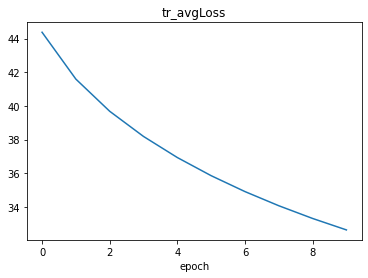

In [23]:
import matplotlib.pyplot as plt
plt.plot(tr_Loss)
plt.xlabel("epoch")

plt.title("tr_avgLoss")

In [17]:
tr_Loss[-1]

32.630011876424156

Text(0.5, 1.0, 'cv_Loss')

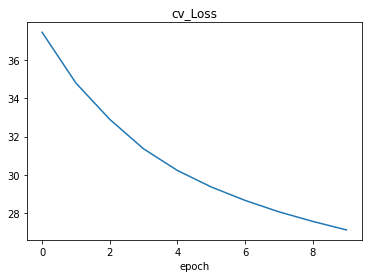

In [13]:
import matplotlib.pyplot as plt
plt.plot(cv_Loss)
plt.xlabel("epoch")
plt.title("cv_Loss")

Text(0.5, 1.0, 'tr_Loss')

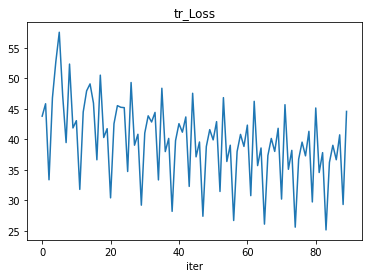

In [14]:
import matplotlib.pyplot as plt
plt.plot(LOSS)
plt.xlabel("iter")
plt.title("tr_Loss")

Text(0.5, 1.0, 'cv_Loss_iter')

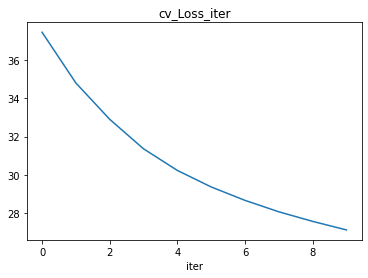

In [15]:
import matplotlib.pyplot as plt
plt.plot(cvloss)
plt.xlabel("iter")
plt.title("cv_Loss_iter")

In [16]:
!nvidia-smi

Wed Nov 11 07:58:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P2    44W / 180W |   7339MiB /  8116MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# save model

In [52]:
epoch=2000
cv_loss=val_loss
tr_loss=tr_avg_loss

In [53]:
file_path = os.path.join(save_folder, 'epoch%d.pth.tar' % (epoch + 1))
torch.save(model.module.serialize(model.module, optimizer, epoch + 1,tr_loss=tr_loss, cv_loss=cv_loss), file_path)
print('Saving checkpoint model to %s' % file_path)

Saving checkpoint model to exp/temp/epoch2001.pth.tar


# evaluate

In [55]:
#!/usr/bin/env python

# Created on 2018/12
# Author: Kaituo XU

# import argparse
import os

import librosa
from mir_eval.separation import bss_eval_sources
import numpy as np
import torch

# from data import AudioDataLoader, AudioDataset
# from pit_criterion import cal_loss
# from conv_tasnet import ConvTasNet
# from utils import remove_pad
"""
    Evaluate separation performance using Conv-TasNet
"""
model_path="/home/speech/f_torch/bin/exp/temp/epoch2001.pth.tar"
#'Path to model file created by training'
# parser = argparse.ArgumentParser('Evaluate separation performance using Conv-TasNet')
# parser.add_argument('--model_path', type=str, required=True,
#                     help='Path to model file created by training')
# parser.add_argument('--data_dir', type=str, required=True,
#                     help='directory including mix.json, s1.json and s2.json')
data_dir="/home/speech/f_torch/bin/stream_data_1sec/outdata/tt"
#'directory including mix.json, s1.json and s2.json'
# parser.add_argument('--cal_sdr', type=int, default=0,
#                     help='Whether calculate SDR, add this option because calculation of SDR is very slow')
cal_sdr=0
#'Whether calculate SDR, add this option because calculation of SDR is very slow'
# parser.add_argument('--use_cuda', type=int, default=0,
#                     help='Whether use GPU')
use_cuda=0
#'Whether use GPU'
# parser.add_argument('--sample_rate', default=8000, type=int,
#                     help='Sample rate')
sample_rate=16000
# parser.add_argument('--batch_size', default=1, type=int,
#                     help='Batch size')
batch_size=batch_size


def evaluate(model_path , data_dir , cal_sdr , use_cuda , sample_rate , batch_size):
    total_SISNRi = 0
    total_SDRi = 0
    total_cnt = 0

    # Load model
    model = ConvTasNet.load_model(model_path)
    print(model)
    model.eval()
    if use_cuda:
        model.cuda()

    # Load data
    dataset = AudioDataset(data_dir, batch_size,
                           sample_rate=sample_rate, segment=-1)
    data_loader = AudioDataLoader(dataset, batch_size=1, num_workers=2)

    with torch.no_grad():
        for i, (data) in enumerate(data_loader):
            # Get batch data
            padded_mixture, mixture_lengths, padded_source = data
            if use_cuda:
                padded_mixture = padded_mixture.cuda()
                mixture_lengths = mixture_lengths.cuda()
                padded_source = padded_source.cuda()
            # Forward
            estimate_source = model(padded_mixture)  # [B, C, T]
            loss, max_snr, estimate_source, reorder_estimate_source = \
                cal_loss(padded_source, estimate_source, mixture_lengths)
            # Remove padding and flat
            mixture = remove_pad(padded_mixture, mixture_lengths)
            source = remove_pad(padded_source, mixture_lengths)
            # NOTE: use reorder estimate source
            estimate_source = remove_pad(reorder_estimate_source,
                                         mixture_lengths)
            # for each utterance
            for mix, src_ref, src_est in zip(mixture, source, estimate_source):
                print("Utt", total_cnt + 1)
                # Compute SDRi
                if cal_sdr:
                    avg_SDRi = cal_SDRi(src_ref, src_est, mix)
                    total_SDRi += avg_SDRi
                    print("\tSDRi={0:.2f}".format(avg_SDRi))
                # Compute SI-SNRi
                avg_SISNRi = cal_SISNRi(src_ref, src_est, mix)
                print("\tSI-SNRi={0:.2f}".format(avg_SISNRi))
                total_SISNRi += avg_SISNRi
                total_cnt += 1
    if cal_sdr:
        print("Average SDR improvement: {0:.2f}".format(total_SDRi / total_cnt))
    print("Average SISNR improvement: {0:.2f}".format(total_SISNRi / total_cnt))


def cal_SDRi(src_ref, src_est, mix):
    """Calculate Source-to-Distortion Ratio improvement (SDRi).
    NOTE: bss_eval_sources is very very slow.
    Args:
        src_ref: numpy.ndarray, [C, T]
        src_est: numpy.ndarray, [C, T], reordered by best PIT permutation
        mix: numpy.ndarray, [T]
    Returns:
        average_SDRi
    """
    src_anchor = np.stack([mix, mix], axis=0)
    sdr, sir, sar, popt = bss_eval_sources(src_ref, src_est)
    sdr0, sir0, sar0, popt0 = bss_eval_sources(src_ref, src_anchor)
    avg_SDRi = ((sdr[0]-sdr0[0]) + (sdr[1]-sdr0[1])) / 2
    # print("SDRi1: {0:.2f}, SDRi2: {1:.2f}".format(sdr[0]-sdr0[0], sdr[1]-sdr0[1]))
    return avg_SDRi


def cal_SISNRi(src_ref, src_est, mix):
    """Calculate Scale-Invariant Source-to-Noise Ratio improvement (SI-SNRi)
    Args:
        src_ref: numpy.ndarray, [C, T]
        src_est: numpy.ndarray, [C, T], reordered by best PIT permutation
        mix: numpy.ndarray, [T]
    Returns:
        average_SISNRi
    """
    sisnr1 = cal_SISNR(src_ref[0], src_est[0])
    sisnr2 = cal_SISNR(src_ref[1], src_est[1])
    sisnr1b = cal_SISNR(src_ref[0], mix)
    sisnr2b = cal_SISNR(src_ref[1], mix)
    # print("SISNR base1 {0:.2f} SISNR base2 {1:.2f}, avg {2:.2f}".format(
    #     sisnr1b, sisnr2b, (sisnr1b+sisnr2b)/2))
    # print("SISNRi1: {0:.2f}, SISNRi2: {1:.2f}".format(sisnr1, sisnr2))
    avg_SISNRi = ((sisnr1 - sisnr1b) + (sisnr2 - sisnr2b)) / 2
    return avg_SISNRi


def cal_SISNR(ref_sig, out_sig, eps=1e-8):
    """Calcuate Scale-Invariant Source-to-Noise Ratio (SI-SNR)
    Args:
        ref_sig: numpy.ndarray, [T]
        out_sig: numpy.ndarray, [T]
    Returns:
        SISNR
    """
    assert len(ref_sig) == len(out_sig)
    ref_sig = ref_sig - np.mean(ref_sig)
    out_sig = out_sig - np.mean(out_sig)
    ref_energy = np.sum(ref_sig ** 2) + eps
    proj = np.sum(ref_sig * out_sig) * ref_sig / ref_energy
    noise = out_sig - proj
    ratio = np.sum(proj ** 2) / (np.sum(noise ** 2) + eps)
    sisnr = 10 * np.log(ratio + eps) / np.log(10.0)
    return sisnr


if __name__ == '__main__':
#     /args = parser.parse_args()
#     print(args)
    evaluate(model_path , data_dir , cal_sdr , use_cuda , sample_rate , batch_size)

ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(1, 256, kernel_size=(20,), stride=(10,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
          (0): TemporalBlock(
            (net): Sequential(
              (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
              (1): PReLU(num_parameters=1)
              (2): GlobalLayerNorm()
              (3): DepthwiseSeparableConv(
                (net): Sequential(
                  (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512, bias=False)
                  (1): PReLU(num_parameters=1)
                  (2): GlobalLayerNorm()
                  (3): Conv1d(512, 256, kernel_size=(1,), stride=(1,), bias=False)
                )
              )
            )
          )
          (1): TemporalBlock(
      

Utt 1
	SI-SNRi=-0.46
Utt 2
	SI-SNRi=-3.68
Average SISNR improvement: -2.07


# separate

In [59]:
!pip install librosa==0.6

In [60]:
print(librosa.__version__)

0.8.0


In [76]:
preprocess_one_dir(in_dir='/home/speech/f_torch/bin/stream_data_1sec/data/test', out_dir='/home/speech/f_torch/bin/stream_data_1sec/data/test', out_filename='mix', sample_rate=16000)

In [79]:
#!/usr/bin/env python

# Created on 2018/12
# Author: Kaituo XU

# import argparse
import os

import librosa
import torch

# from data import EvalDataLoader, EvalDataset
# from conv_tasnet import ConvTasNet
# from utils import remove_pad
'''
Separate speech using Conv-TasNet
'''
# parser = argparse.ArgumentParser('Separate speech using Conv-TasNet')
model_path='/home/speech/f_torch/bin/exp/temp/epoch2001.pth.tar'
#Path to model file created by training'
# parser.add_argument('--model_path', type=str, required=True,
#                     help='Path to model file created by training')
# parser.add_argument('--mix_dir', type=str, default=None,
#                     help='Directory including mixture wav files')
mix_dir='/home/speech/f_torch/bin/stream_data_1sec/data/test'
#'Directory including mixture wav files'
# parser.add_argument('--mix_json', type=str, default=None,
#                     help='Json file including mixture wav files')
mix_json='/home/speech/f_torch/bin/stream_data_1sec/data/test'
# 'Json file including mixture wav files'
# parser.add_argument('--out_dir', type=str, default='exp/result',
#                     help='Directory putting separated wav files')
out_dir='/home/speech/f_torch/bin/stream_data_1sec/data/test/result'
#Directory putting separated wav files
#
# parser.add_argument('--use_cuda', type=int, default=0,
#                     help='Whether use GPU to separate speech')
use_cuda=0
# parser.add_argument('--sample_rate', default=8000, type=int,
#                     help='Sample rate')
sample_rate=16000
batch_size=batch_size
# parser.add_argument('--batch_size', default=1, type=int,
#                     help='Batch size')
import soundfile

def separate(model_path,mix_dir,mix_json,out_dir,use_cuda , sample_rate , batch_size):
    if mix_dir is None and mix_json is None:
        print("Must provide mix_dir or mix_json! When providing mix_dir, "
              "mix_json is ignored.")

    # Load model
    model = ConvTasNet.load_model(model_path)
    print(model)
    model.eval()
    if use_cuda:
        model.cuda()

    # Load data
    eval_dataset = EvalDataset(mix_dir, mix_json,
                               batch_size=batch_size,
                               sample_rate=sample_rate)
    eval_loader =  EvalDataLoader(eval_dataset, batch_size=1)
    os.makedirs(out_dir, exist_ok=True)

    def write(inputs, filename, sr=sample_rate):
        soundfile.write(file=filename, data=inputs, samplerate=sr, subtype=None, endian=None, format=None, closefd=True)
#         librosa.output.write_wav(filename, inputs, sr)# norm=True)


    with torch.no_grad():
        for (i, data) in enumerate(eval_loader):
            # Get batch data
            mixture, mix_lengths, filenames = data
            if use_cuda:
                mixture, mix_lengths = mixture.cuda(), mix_lengths.cuda()
            # Forward
            estimate_source = model(mixture)  # [B, C, T]
            # Remove padding and flat
            flat_estimate = remove_pad(estimate_source, mix_lengths)
            mixture = remove_pad(mixture, mix_lengths)
            # Write result
            for i, filename in enumerate(filenames):
                filename = os.path.join(out_dir,
                                        os.path.basename(filename).strip('.wav'))
                write(mixture[i], filename + '.wav')
                C = flat_estimate[i].shape[0]
                for c in range(C):
                    write(flat_estimate[i][c], filename + '_s{}.wav'.format(c+1))


if __name__ == '__main__':
#     args = parser.parse_args()
#     print(args)
    separate(model_path,mix_dir,mix_json,out_dir,use_cuda , sample_rate , batch_size)

ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(1, 256, kernel_size=(20,), stride=(10,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
          (0): TemporalBlock(
            (net): Sequential(
              (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
              (1): PReLU(num_parameters=1)
              (2): GlobalLayerNorm()
              (3): DepthwiseSeparableConv(
                (net): Sequential(
                  (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512, bias=False)
                  (1): PReLU(num_parameters=1)
                  (2): GlobalLayerNorm()
                  (3): Conv1d(512, 256, kernel_size=(1,), stride=(1,), bias=False)
                )
              )
            )
          )
          (1): TemporalBlock(
      

# #plot spectrogram

/home/speech/f_torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/speech/f_torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


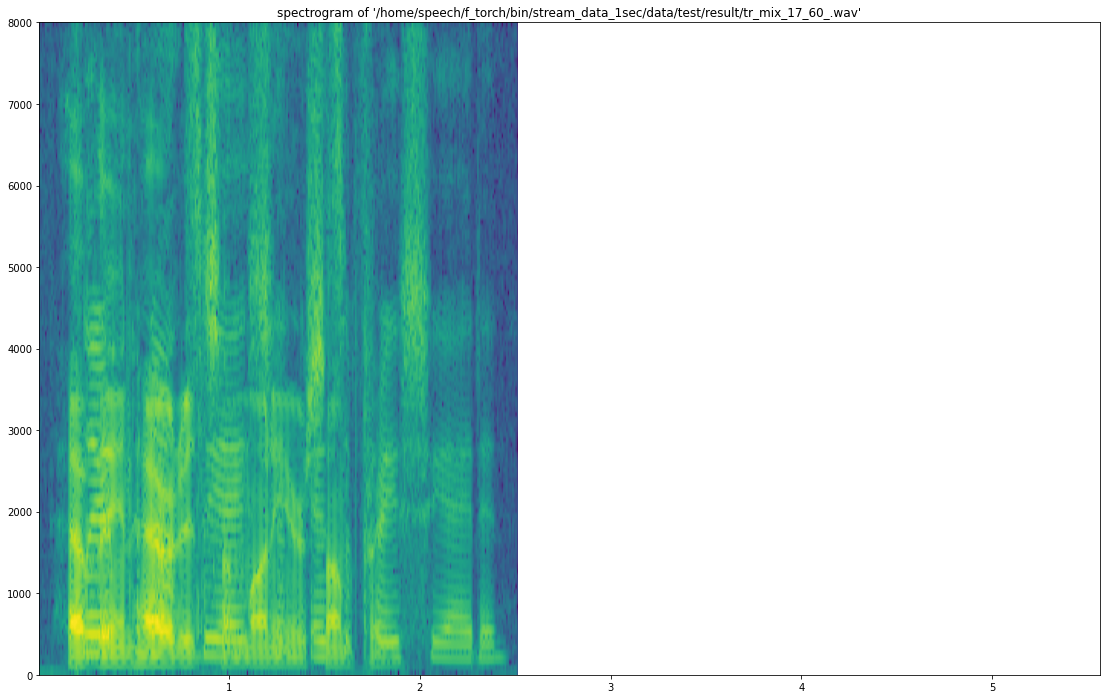

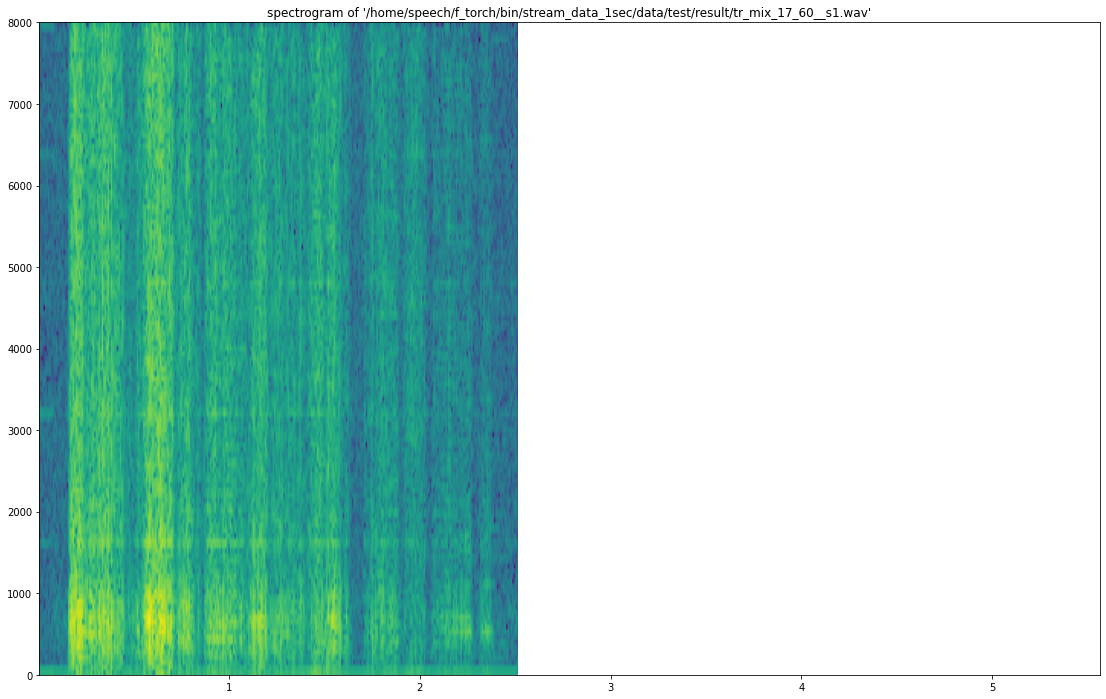

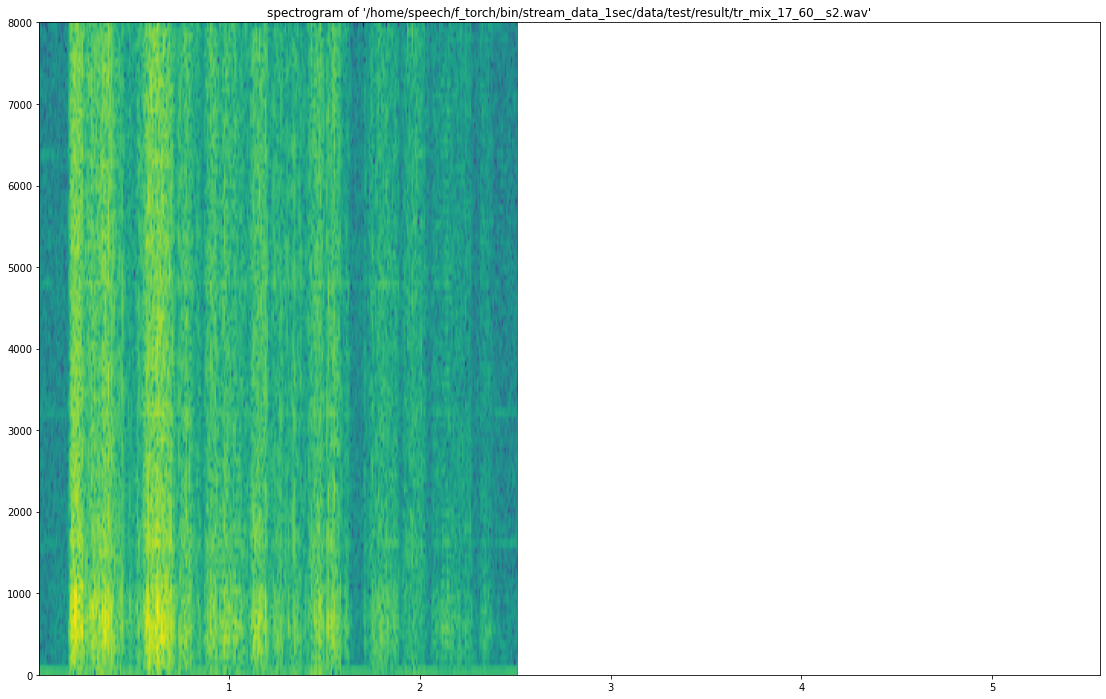

In [88]:
# import matplotlib.pyplot as plt
# from scipy import signal
# from scipy.io import wavfile

# sample_rate, samples = wavfile.read('/home/speech/f_torch/bin/stream_data_1sec/data/tr/s1/tr_s1_4_1sec.wav')
# frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

graph_spectrogram('/home/speech/f_torch/bin/stream_data_1sec/data/test/result/tr_mix_17_60_.wav')
graph_spectrogram('/home/speech/f_torch/bin/stream_data_1sec/data/test/result/tr_mix_17_60__s1.wav')
graph_spectrogram('/home/speech/f_torch/bin/stream_data_1sec/data/test/result/tr_mix_17_60__s2.wav')

/home/speech/f_torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


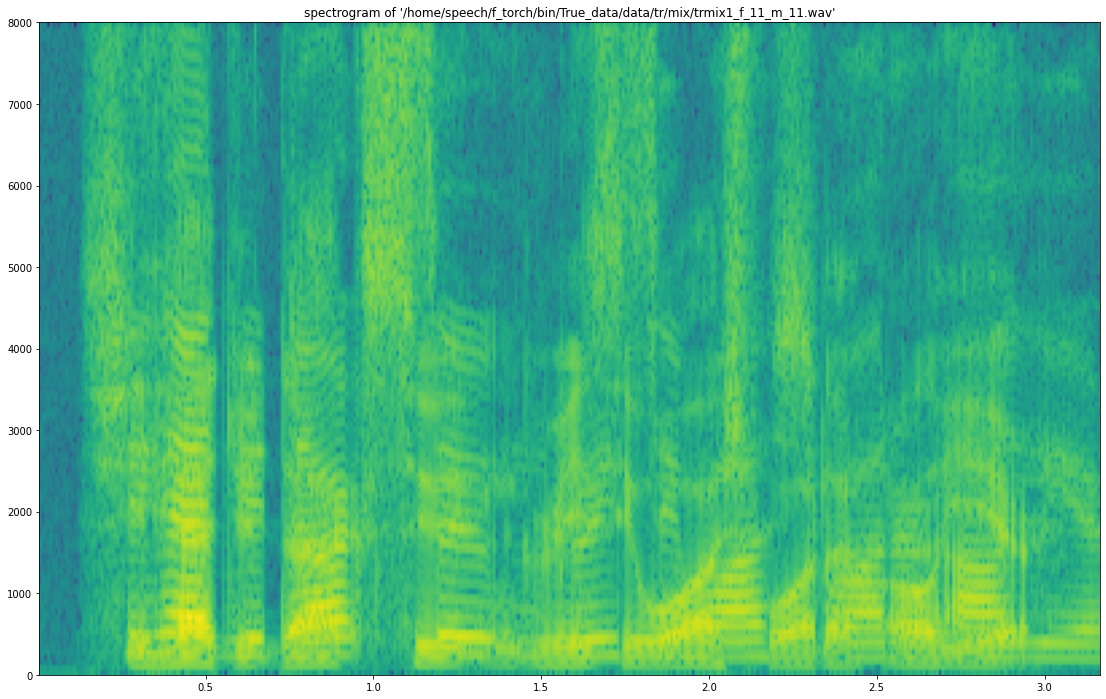

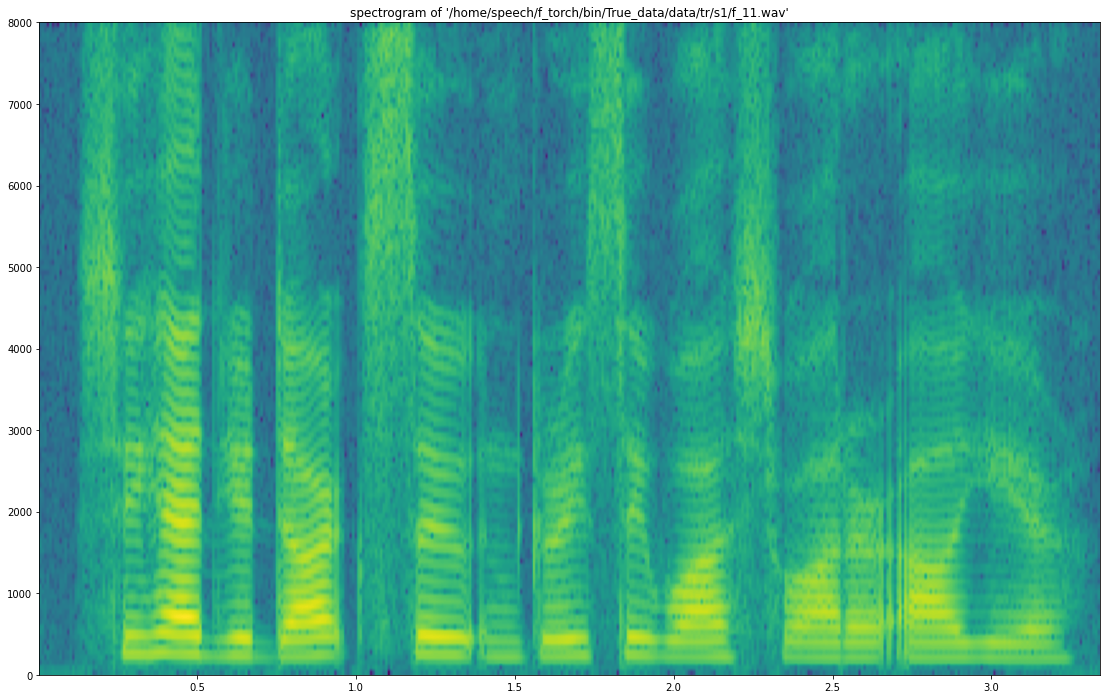

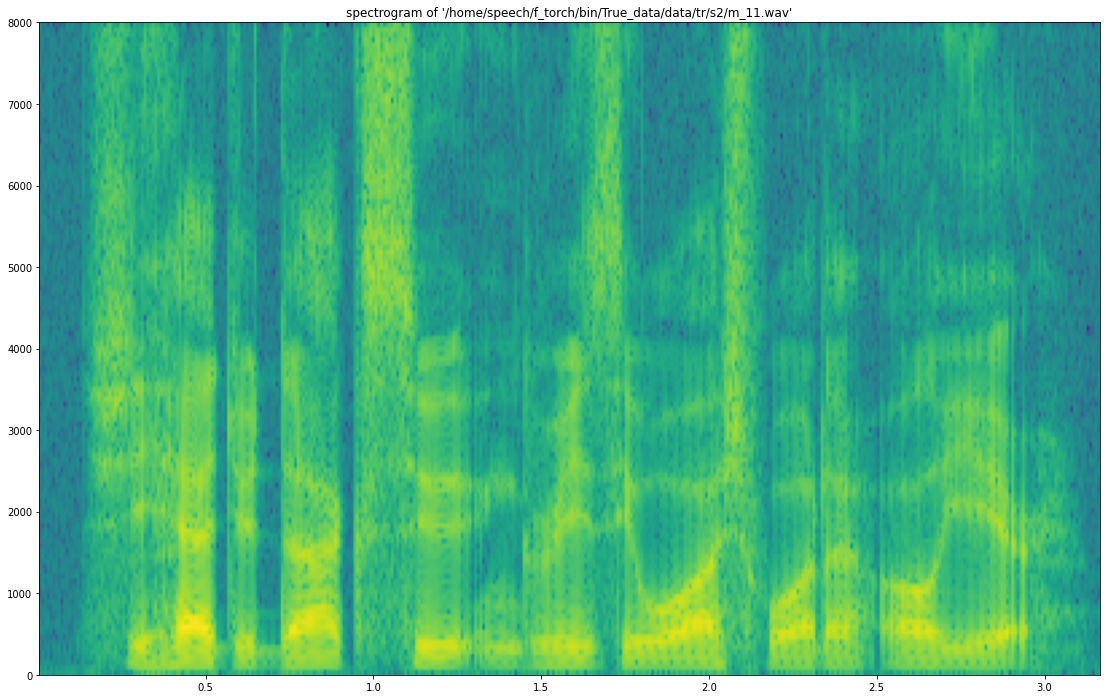

In [89]:
graph_spectrogram('/home/speech/f_torch/bin/True_data/data/tr/mix/trmix1_f_11_m_11.wav')
graph_spectrogram('/home/speech/f_torch/bin/True_data/data/tr/s1/f_11.wav')
graph_spectrogram('/home/speech/f_torch/bin/True_data/data/tr/s2/m_11.wav')